# Project: Climate Change - Web Scraping

Topics discussed:
- Project Topic: Climate Change  
- Web scraping and Article persistence
- Article parsing and Metadata File
- Sentence Samples
- Additional: Manual file division and merging
- Additional: Keyword Network Analysis
- Additional: Similarities Between Articles
- Additional: Wordcloud - Year and Gender based

# Climate Change

Climate change is a popular topic of conversations in multiple platforms. The topic seems to be a reoccurring theme in most political agendas, depending on an individual’s belief climate change is either a real phenomenon and something that needs to be addressed or it is fuel for a platform to hurt the oil industry and disrupt economic behavior. Regardless of one’s 
stance on the topic, the scientific community is constantly warning the public about the catastrophic impacts from climate change and something needs to be done. 

Climate change is relevant to today’s world with a lot of points and ideas that need to be 
investigated. The purpose of our project is to dive deep into the climate change ideas and 
uncover the underlying tone of the articles We were also interested to find whether the authors are inclined to any specific articles based on their gender or whether articles have any importance with the time it was written. The climate change related topics were found under the URL, https://theconversation.com/us/topics/climate-change-27

In [1]:
from IPython.display import Image
Image(url="resources/conversation.jpg")

## Website facts

- First launched in Autralia-based out of Melbourne in 2011, now in 7 additional countries

- 10.7 million users and reaches 40 million readers

- Each edition is funded by independent not for profit charties

## Operating model 

- Articles written by academics, based on their area of research. The Conversation aims for no jargon and easily accessible to a wide audience.

- Interesting note: in 2016 they implemented a factchecking team and one of only two units accredited by the international fact-checking network

In [2]:
Image(url="resources/conversation.png")

## Web Scraping and Creation of metadata file

Every article had a title, author, date the article was written and the URL to the full article. Since the article listing page had all the above information, we decided to extract this information together with saving each of the corresponding article page. In that way we could create the metadata file and all the article files within one programming loop.

In [3]:
# Imports used for web scraping related task
from bs4 import BeautifulSoup
from pandas import DataFrame
import requests
import nltk
import os
import re

# Imports used for Additional research
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
import gender_guesser.detector as g
from IPython.display import Image
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
import networkx as nx
import pandas as pd
import string

In [4]:
# Create a list of all page URL's to be scraped
url="https://theconversation.com/us/topics/climate-change-27?page={}"
pages = 197
urls=[url.format(i) for i in range(1, pages)]

We found having the below clean_text() function to be useful since it was re-used several times in the code. It also helped us keep this logic contained at one place. The function removes new lines, tabs and spaces in unicode char

In [5]:
# Reusable function for cleaning text
def clean_text(uncleantext):
    return uncleantext.strip().replace("\n","").replace("\t"," ").replace("\r","").replace("\xa0"," ")


Preparation of files and folders. Maintaining all the files at one place help maintaining the name of the files or moving the files to a different folder easier.

In [6]:
# Folder where article pages (html files) will get persisted
article_folder="articles/"

# Article Metadata file; deliverable for this project
article_metadata_file= "_article_metadata.csv"

# File to store all sentences from all the articles
sentences_file = "resources/_sentences.csv"

# File to store random 2000 sentences for manual sentiment classification
sentiments_file = "resources/_sentiments.csv"

# Delete files from article_folder
for root, dirs, files in os.walk(article_folder):
    for file in files:
        os.remove(os.path.join(article_folder, file))

In [7]:
# Unique sequence number for file names
k=0

# Loop through the page URL's
for url in urls:
    r = requests.get(url)
    soup = BeautifulSoup(r.content, "html.parser")
    h3_list = soup.find_all("article",{"class": "clearfix placed analysis published"})

    # Loop through all the articles in the page
    for h3 in h3_list:
        k = k + 1
        pp = h3.header.div.find("h2").find("a")
        topicurl = "https://theconversation.com" + clean_text(pp["href"])
        title = clean_text(pp.text) 

        # Create unique file names for the article prefixing a unique number
        file_name = str(k)+"-" + ''.join(e for e in title if e.isalnum()).lower() 
        file_name = file_name[:50] + ".html"

        # Write each article URL as an HTML file
        with open(article_folder + file_name, "w+b") as fw:
            rr = requests.get(topicurl)
            fw.write(rr.content)


## Article Parsing

Parse the HTML code of each article and extract the following information from the article:
- Article title 
- Article body text 
- Posting date and time 
- Author/s 

Extracted information from all the articles are saved in a single CSV file, in which a row corresponds to an article.

In [8]:
# Some authors did not have a link. Below code handles both scenario's
def get_author(li):
    if li.a:
        return clean_text(li.a.span.text)
    elif li.span:
        return clean_text(li.span.text)

with open(article_metadata_file, "w", encoding="utf8") as mfw:
    mfw.write("{}\t{}\t{}\t{}\n".format("article_title", "article_body_text", "posting_date_time", "authors"))
    for file_name in os.listdir(article_folder):
        if not file_name.endswith(".html"):
            continue

        # Read each article file and scrape the metadata information
        with open(article_folder + file_name, "r+b") as fr:
            soup = BeautifulSoup(fr.read(), "html.parser")
            
            article_title = soup.find("h1", {"class": "legacy entry-title instapaper_title"}).strong.text
            article_title = clean_text(article_title)
            
            article_body = soup.find("div", {"itemprop": "articleBody"}).text
            article_body = clean_text(article_body)
            
            article_time = soup.find("time", {"itemprop": "datePublished"}).text
            article_time = clean_text(article_time)
            
            article_authors_li = soup.find("div", {"class": "content-authors-group"}).find_all("li")
            # Loop through all the authors 
            article_authors = ""
            for num, li in enumerate(article_authors_li, start=1):
                if num == 1:
                    article_authors = get_author(li)
                else:
                    article_authors = article_authors + ", " + get_author(li)
            article_authors = clean_text(article_authors)
            
            
            mfw.write("{}\t{}\t{}\t{}\n".format(article_title, article_body, article_time, article_authors))

## Create sentences from articles

Tokenize the body text in all the articles into sentences and merged all the identified sentences. A random sample of 2,000 sentences were picked from all the sentences and written to a csv file with an empty sentiment column for using later.

In [9]:

# Open sentences_file for writing all article sentences
with open(sentences_file, "w", encoding="utf8") as mfw:
    
    # Read each article body from the article metadata file
    with open(article_metadata_file, "r") as fr:
        lines = fr.readlines() 
        # Skip the header line
        for line in lines[1:]:
            article_title, article_body, article_time, authors = line.split("\t")
            # Fix for periods not followed by a space. 
            # Place a space after the period if a lowercase letter is followed by a period followed by a uppercase 
            article_body = re.sub(r'([a-z])\.([A-Z])', r'\1. \2', article_body)
            sentences = nltk.sent_tokenize(article_body)  
            
            for sentence in sentences:
                mfw.write("{}\n".format(sentence))

## Manual sentiment classification

In [10]:
# Select a random set of 2000 sentences and store them in sentiments_file
sample_size = 2000

with open(sentences_file, mode="r") as fr:
    lines = fr.readlines() 
    df = DataFrame(lines)
    
    if len(df) < sample_size:
        sample_size = len(df)
        
    df = df.sample(n=sample_size, replace=False, random_state=5) 
    filtered = df.values.tolist()

    with open(sentiments_file, "w", encoding="utf8") as fw:
        fw.write("Sentence\tSentiment\n")
        for item in filtered:
            sentence = "".join(item).replace("\n","")
            fw.write("{}\t{}\n".format(sentence,""))

## Additional Research and Code

### Splitting and Merging of csv for manual sentiment classification

Divide the sentiments_file to 3 files for manual sentiment classification by team members. We kept the manual classification very simple by only having 3 sentiments; Neutral, Negative and Positive. The below code shows how we divided the sentences for manual classification.

In [11]:
# Divide the sentiments_file to 3 parts for parellal work of manual classification
with open(sentiments_file, 'r') as fr:
    csvfile = fr.readlines()

team_members = 3
linesPerFile = round(sample_size/ team_members)
filename = 1
all_filenames = []

for i in range(0,len(csvfile),linesPerFile):
    memberfilename = sentiments_file.replace(".", str(filename)+".") 
    all_filenames.append(memberfilename)
    with open(memberfilename, 'w+') as f:
        if filename > 1: 
            f.write(csvfile[0])
        f.writelines(csvfile[i:i+linesPerFile])
    filename += 1
    

The below logic is for combining all the files after manually classifying the sentiments of the sample sentences. The file name in the code is given differently so that the code will not overwrite our actual file with manual classification. The actual file we used was resources/\_sentiments\_target.csv

In [12]:
# Combine all files after manual classification
combined_file = "resources/_sentiments_target1.csv"
all_lines = []
for file in all_filenames:
    with open(file, mode="r") as fr:
        all_lines.append("".join(fr.readlines()[1:])) 
    with open(combined_file, mode="w") as fw:
        fw.write("Sentence\tSentiment\n")
        fw.write("\n".join(all_lines))

### Keyword Network Analysis

Additional research on the climate data to find the word co-occurrences by ploting a keyword network analysis graph 

In [13]:
# Stopwords related to the climate change dataset"
global_stopwords = stopwords.words("english")
local_stopwords = [c for c in string.punctuation] +\
                  ['’', '...', '``', '–', "''", '“', '”', "'m", "'re", "'s", "amp", "n't", 'climate', 'get', 'would',
                      'also', 'one', 'like', 'may', 'need', 'even', 'new', 'many', 'could', 'much', 'read', 'first', 'two',
                      'less', 'way', 'example', 'make', 'use', 'around', 'year', 'years', 'time', 'change', 'changes',
                      '‘', '—', 'must']

Sentences from the sentence file was used here as the word set for the counter. When we used the whole article as the word set, we did not get a good outcome. 

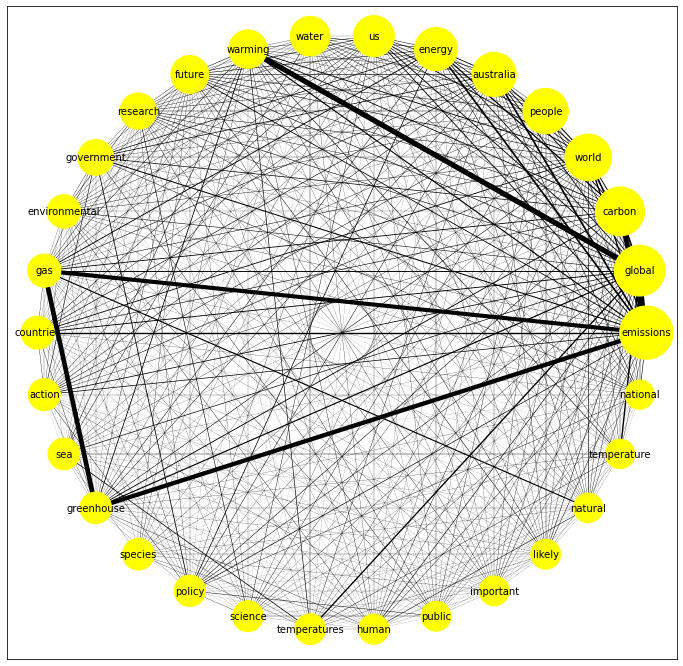

In [14]:
# The 'counter' object will have all the word count information. 
counter = Counter()
co_counter = dict()

with open(sentences_file, "r") as fr:
    lines = fr.readlines()           
    for line in lines:
        word_set = set()
        l = nltk.word_tokenize(line)
        for t in l:
            word = t.lower()
            if (word not in (global_stopwords + local_stopwords)):
                word_set.add(word)
        counter.update(word_set)

        # Calculate co-occurrence count of two words and save it in 'co_counter' 
        words = list(word_set)
        for word1 in words:
            if word1 not in co_counter:
                co_counter[word1] = dict()
            for word2 in words:
                if word1 == word2:
                    continue

                if word2 not in co_counter[word1]:
                    co_counter[word1][word2] = 1
                else:
                    co_counter[word1][word2] += 1

# Define graph and its properties                
G = nx.Graph()
num_nodes = 30

nodes = [item[0] for item in counter.most_common(num_nodes)]
node_weights = [item[1] / 3 for item in counter.most_common(num_nodes)]

for word in nodes:
    G.add_node(word, weight=counter.get(word))
    
for word1 in nodes:
    for word2 in nodes:
        if (word1 != word2) & (word2 in co_counter[word1]):
            G.add_edge(word1, word2, weight=co_counter[word1][word2])
            
edges = nx.get_edge_attributes(G, "weight").keys()
edge_weights = nx.get_edge_attributes(G, "weight").values()
edge_weights = [item / 400 for item in edge_weights]

plt.figure(figsize=(12, 12))

# Render graph
nx.draw_networkx(G, pos=nx.circular_layout(G), 
                 nodelist=nodes, node_size=node_weights, edgelist=edges, width=edge_weights,
                 node_color="yellow", with_labels=True, font_size=10)
plt.draw()

### Article Similarities

A comparison study of article titles to find similarities between them and to find the authors of those similar articles and dates when the articles were written.

In [15]:
# Extracted the title, author and date from the metadata file
titles = []
author = []
date = []
year = []
with open(article_metadata_file, "r") as fr:
    lines = fr.readlines() 
    for line in lines[1:]:
        article_title, article_body, article_date, article_author = line.split("\t")
        titles.append(article_title)
        date.append(article_date)
        year.append(re.findall("\d, (\d\d\d\d) \d", article_date)[0])
        author.append(clean_text(article_author))

In [16]:
# TfidfVectorizer initialization; Document term matrix was created based on the article titles 
vectorizer = TfidfVectorizer(use_idf=True, norm="l2", stop_words=global_stopwords+local_stopwords, max_df=0.8)
dtm = vectorizer.fit_transform(titles)

In [17]:
# Text similarity using cosine similarity
df2_sim = pd.DataFrame(data=cosine_similarity(dtm))
tuples = []
for pos1 in df2_sim.index:
    for pos2 in df2_sim.index:
        if pos1 != pos2:
            title1 = titles[pos1]
            title2 = titles[pos2]
            
            # Skip if the first 20 characters of one tittle are in the other tittle
            if (title1[:20] in title2) | (title2[:20] in title1):
                continue
            
            sim = df2_sim[pos2][pos1]
            if (sim > 0.7) & (sim < 1):
                # Filtering out existing tuples
                filter_tuples =  [item for item in tuples if item[0] == pos2 and item[1] == pos1]
                if len(filter_tuples) == 0 :
                    tuples.append((pos1,pos2))
                    print("{} | {} | {} ".format(year[pos1], titles[pos1], author[pos1]))
                    print("{} | {} | {} ".format(year[pos2], titles[pos2], author[pos2]), end="\n\n")
                    # print("{:.2f} ".format(sim))
        

2017 | If we stopped emitting greenhouse gases right now, would we stop climate change? | Richard B. (Ricky) Rood 
2014 | What would happen to the climate if we stopped emitting greenhouse gases today? | Richard B. (Ricky) Rood 

2019 | Greenland has lost 3.8 trillion tonnes of ice since 1992 | Inès Otosaka, Andrew Shepherd 
2018 | Antarctica has lost nearly 3 trillion tonnes of ice since 1992 | Thomas Slater, Andrew Shepherd 

2018 | 3 dangers of rising temperatures that could affect your health now | Elena N. Naumova 
2019 | How rising temperatures affect our health | Liz Hanna 

2015 | Is the global warming ‘hiatus’ over? | Kevin Trenberth 
2015 | The climate ‘hiatus’ doesn’t take the heat off global warming | Matthew England 

2013 | Is global warming in a hiatus? | Andy Pitman 
2015 | The climate ‘hiatus’ doesn’t take the heat off global warming | Matthew England 

2011 | Explainer: why ocean acidification is the ‘evil twin’ of climate change | Donna Roberts 
2013 | Global warming

### Wordcloud: Year and Gender based

This is another research on climate change data. We wanted to find the buzz-words used in the climate change articles for each year and also used by authors based on their gender. We made some adjustments to the local stopwords to get a more refined list

In [18]:
# Temporary image storage for notebook output
image_file_name = "resources/wordcloud.png"

# Counter for year based words
def yearcounter(year):
    counteryear = Counter()
    with open(article_metadata_file, "r") as fr:
        lines = fr.readlines()           
        for line in lines[1:]:
            article_title, article_body, article_date, article_author = line.split("\t")
            article_year = re.findall("\d, (\d\d\d\d) \d", article_date)[0]
            if article_year != year:
                continue

            word_set = set()
            l = nltk.word_tokenize(article_title)
            for t in l:
                word = t.lower()
                if (word not in (global_stopwords + local_stopwords)):
                    word_set.add(word)
            counteryear.update(word_set)
    return counteryear;

# Counter for gender based words
def gendercounter(gender):
    countergender = Counter()
    d = g.Detector(case_sensitive=False)
    with open(article_metadata_file, "r") as fr:
        lines = fr.readlines()           
        for line in lines[1:]:
            article_title, article_body, article_date, article_author = line.split("\t")
            authors = article_author.split(",")
            if len(authors)>1:
                continue
            author = article_author.split(" ")
            author_gender =  d.get_gender(author[0]) 
            if author_gender == gender or author_gender == 'mostly_'+gender:
                word_set = set()
                l = nltk.word_tokenize(article_title)
                for t in l:
                    word = t.lower()
                    if (word not in (global_stopwords + local_stopwords)):
                        word_set.add(word)
                countergender.update(word_set)
    return countergender;

In [19]:
# Draw wordcloud with dynamic counter
def draw_wordcloud(val, max_words=100):
    if val=='male' or val=='female':
        counter = gendercounter(val)
    else:
        counter = yearcounter(val)

    wc = WordCloud(background_color="white", max_words=max_words, width=800, height=500)
    wc.generate_from_frequencies(counter)
    wc.to_file(image_file_name)
    display(Image(filename=image_file_name))

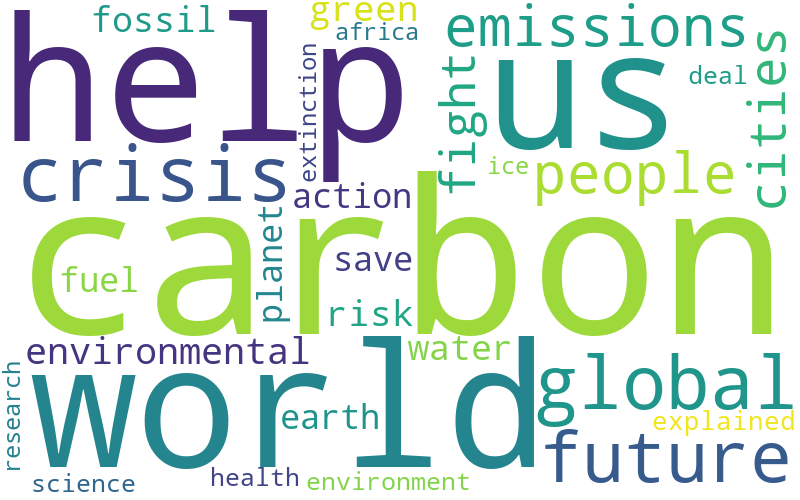

In [20]:
# Updating Local Stopwords for a refined result
local_stopwords = local_stopwords + ['australia']

# Comparing the climate issues in 2019 vs 2020
draw_wordcloud("2019",30)


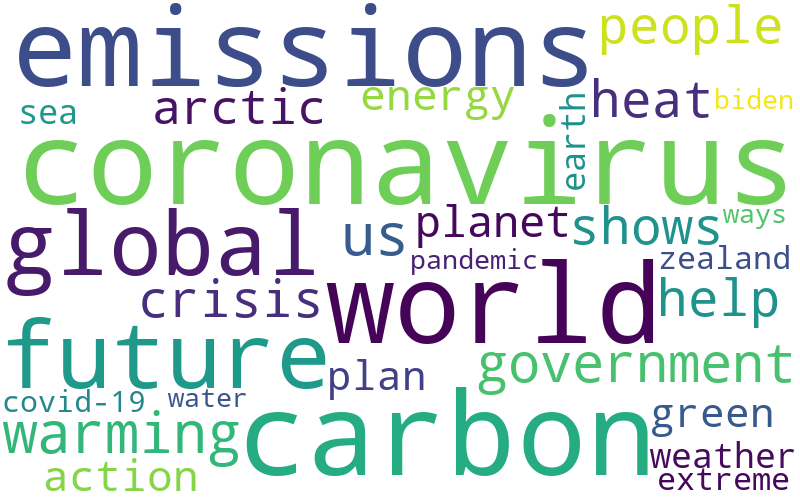

In [21]:
draw_wordcloud("2020",30)
# draw_wordcloud("2010")


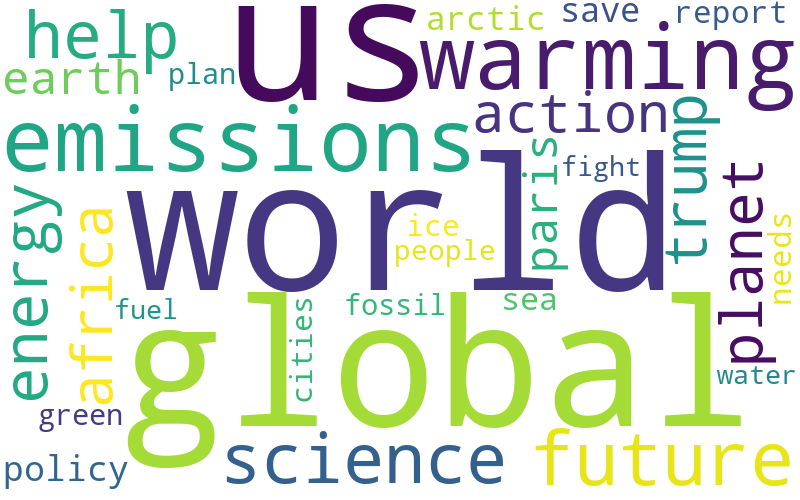

In [22]:
# Updating Local Stopwords for a refined result
local_stopwords = local_stopwords + ['carbon']

# Comparing the climate issues by male vs female authors
draw_wordcloud("male",30)


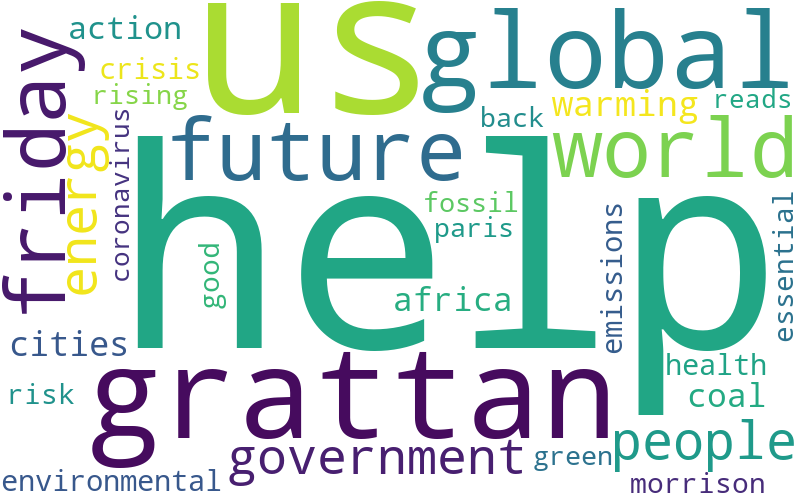

In [23]:
draw_wordcloud("female",30)

## Deliverables

- +3,000 HTML files can be found in folder; articles/ 
- CSV file with article metadata; _article_metadata.csv
- Jupyter notebook with code and output; Part1_WebScraping.ipynb